In [2]:
%load_ext autoreload
%autoreload 2
from scripts.load_data import load_raw_data
import numpy as np
import matplotlib.pyplot as plt
files_lst = load_raw_data('Berea')

# list of digital rock files for "Berea"
files_lst

['c:\\100_Research\\digital_rock\\dataset\\Berea_2d25um_binary.raw',
 'c:\\100_Research\\digital_rock\\dataset\\Berea_2d25um_grayscale.raw',
 'c:\\100_Research\\digital_rock\\dataset\\Berea_2d25um_grayscale_filtered.raw']

In [3]:
# load grayscale, filtered, and binary images into numpy.ndarray
from scripts.load_data import load_with_keyword_among_list
raw = load_with_keyword_among_list(files_lst, 'grayscale.raw')
filtered = load_with_keyword_among_list(files_lst, 'filtered.raw')
binary = load_with_keyword_among_list(files_lst, 'binary.raw')

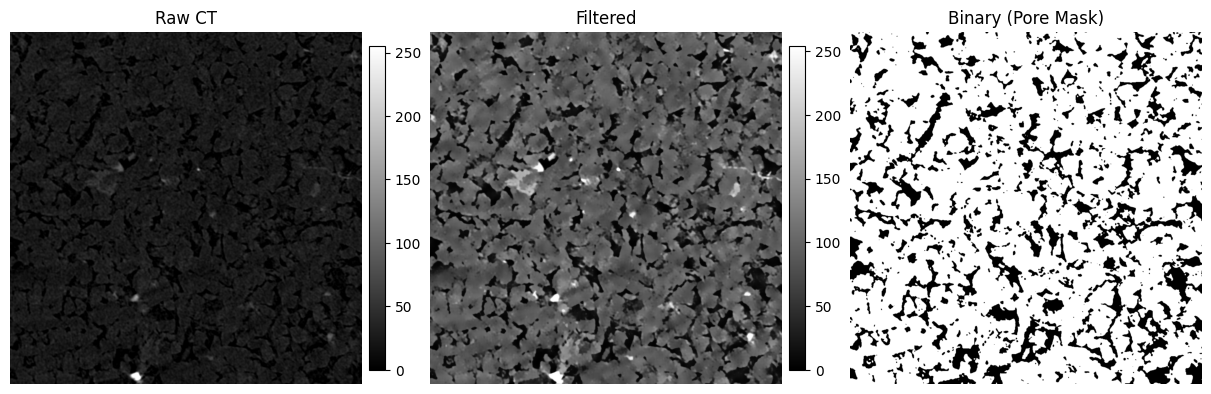

In [4]:
from scripts.visualization import show_raw_filtered_binary
fig = show_raw_filtered_binary(raw=raw, filtered=filtered, binary=binary, slice_idx=0)


In [5]:
from networks.preprocess import make_train_test_paired_datasets

train_ds, test_ds = make_train_test_paired_datasets(
    filtered.astype(np.float32), binary.astype(np.float32),
    train_slices=700, test_slices=300,
    patch_size=128,
    stride=128,                 # <- control stride here
    sampling="grid",           # "grid" (deterministic) or "random"
    train_max_patches=10000,   # <- control training dataset size here
    test_max_patches=3000,     # keep all test patches (or set a number)
    x_norm="uint8_01",
    channels_first=True,
)

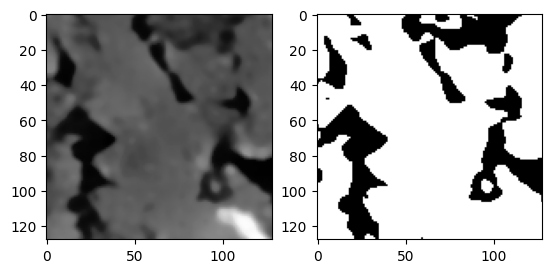

In [7]:
plt.subplot(1,2,1)
plt.imshow(train_ds[0][0].numpy().squeeze(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_ds[0][1].numpy().squeeze(), cmap='gray')

**Using device**: cuda


c:\Users\DELL\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
c:\100_Research\digital_rock\networks\train.py:198: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.amp and device.type == "cuda"))
c:\100_Research\digital_rock\networks\train.py:224: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.amp and device.type == "cuda")):


[Epoch 001/100] train_loss=0.0685 | val_loss=0.0737 | dice=0.9980 | iou=0.9961
[Epoch 002/100] train_loss=0.0157 | val_loss=0.0166 | dice=0.9985 | iou=0.9970
[Epoch 003/100] train_loss=0.0143 | val_loss=285.9518 | dice=0.9951 | iou=0.9916
[Epoch 004/100] train_loss=0.0134 | val_loss=0.0128 | dice=0.9977 | iou=0.9954
[Epoch 005/100] train_loss=0.0127 | val_loss=0.0504 | dice=0.9992 | iou=0.9985
[Epoch 006/100] train_loss=0.0120 | val_loss=0.7014 | dice=0.9984 | iou=0.9969
[Epoch 007/100] train_loss=0.0091 | val_loss=0.0057 | dice=0.9990 | iou=0.9980
[Epoch 008/100] train_loss=0.0081 | val_loss=108.7095 | dice=0.9984 | iou=0.9969
[Epoch 009/100] train_loss=0.0076 | val_loss=26.5531 | dice=0.9992 | iou=0.9985
[Epoch 010/100] train_loss=0.0066 | val_loss=0.5620 | dice=0.9992 | iou=0.9985
[Epoch 011/100] train_loss=0.0066 | val_loss=0.0044 | dice=0.9997 | iou=0.9993
[Epoch 012/100] train_loss=0.0070 | val_loss=1.7491 | dice=0.9983 | iou=0.9967
[Epoch 013/100] train_loss=0.0064 | val_loss=0.

c:\100_Research\digital_rock\networks\train.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)


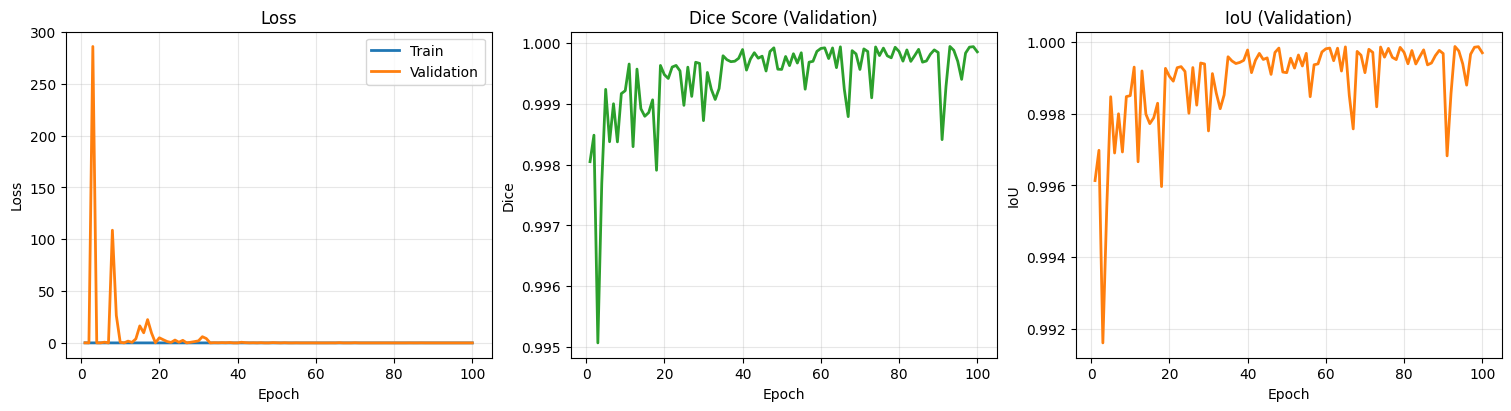

In [8]:
from networks.resunet import ResUNetPlusPlus2D
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print('**Using device**:', device)

# Example: 2D image-to-image
# Input channels: 1 (filtered grayscale) or 3 if you stack features
model = ResUNetPlusPlus2D(in_channels=1, 
                          out_channels=1, 
                          out_activation="none").to(device)

from networks.train import train_resunetpp_2d, plot_training_history, TrainConfig

cfg = TrainConfig(
    epochs=100,
    batch_size=16,
    num_workers=0,
    lr=2e-4,
    grad_clip=1.0,
    amp=True,
    save_dir="checkpoints_resunetpp_2d",
)

model, best, history = train_resunetpp_2d(model, train_ds, test_ds, cfg)
plot_training_history(history)
# print("Best:", best)

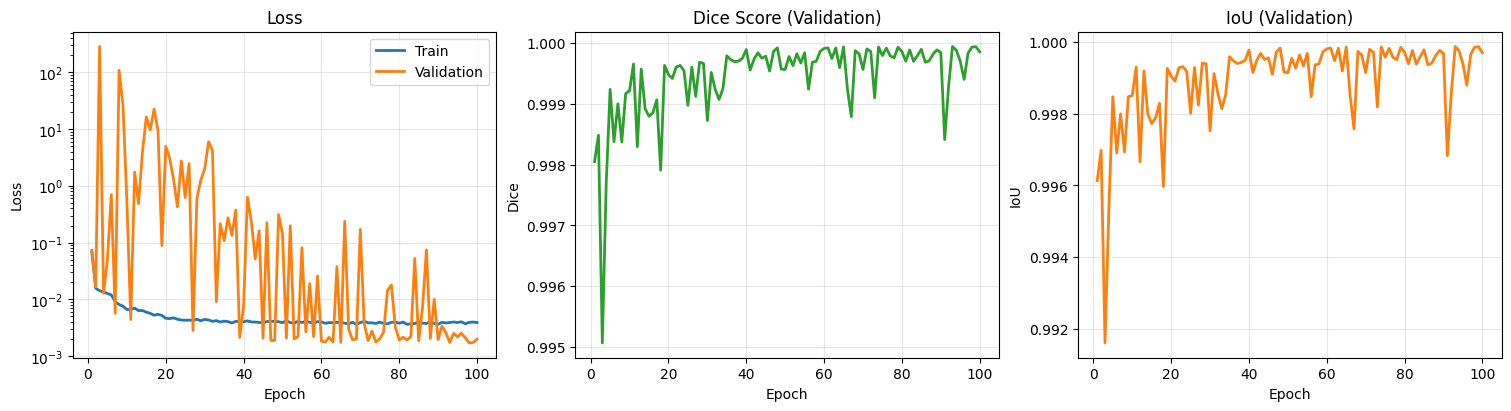

In [9]:
plot_training_history(history)


In [8]:
import pickle
from networks.resunet import ResUNetPlusPlus2D
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print('**Using device**:', device)


**Using device**: cuda


**Using device**: cuda
[Epoch 001/500] train_loss=0.0362 | val_loss=0.0080 | dice=0.9984 | iou=0.9969
[Epoch 002/500] train_loss=0.0070 | val_loss=0.0042 | dice=0.9991 | iou=0.9982
[Epoch 003/500] train_loss=0.0046 | val_loss=0.0029 | dice=0.9994 | iou=0.9988
[Epoch 004/500] train_loss=0.0039 | val_loss=0.0023 | dice=0.9995 | iou=0.9989
[Epoch 005/500] train_loss=0.0031 | val_loss=0.0020 | dice=0.9996 | iou=0.9992
[Epoch 006/500] train_loss=0.0030 | val_loss=0.0019 | dice=0.9995 | iou=0.9990
[Epoch 007/500] train_loss=0.0027 | val_loss=0.0016 | dice=0.9997 | iou=0.9994
[Epoch 008/500] train_loss=0.0027 | val_loss=0.0016 | dice=0.9997 | iou=0.9993
[Epoch 009/500] train_loss=0.0025 | val_loss=0.0013 | dice=0.9998 | iou=0.9995
[Epoch 010/500] train_loss=0.0024 | val_loss=0.0013 | dice=0.9998 | iou=0.9996
[Epoch 011/500] train_loss=0.0022 | val_loss=0.0013 | dice=0.9998 | iou=0.9996
[Epoch 012/500] train_loss=0.0022 | val_loss=0.0011 | dice=0.9998 | iou=0.9996
[Epoch 013/500] train_loss=0.

c:\100_Research\digital_rock\networks\train.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)


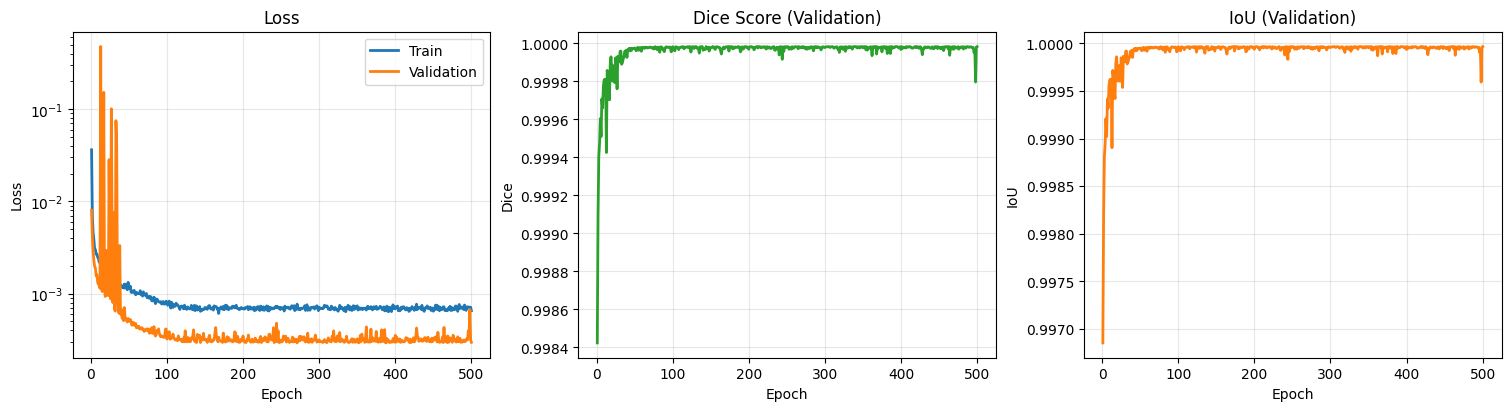

**Using device**: cuda
[Epoch 001/500] train_loss=0.1100 | val_loss=0.0194 | dice=0.9981 | iou=0.9962
[Epoch 002/500] train_loss=0.0167 | val_loss=0.0094 | dice=0.9984 | iou=0.9968
[Epoch 003/500] train_loss=0.0120 | val_loss=0.0073 | dice=0.9987 | iou=0.9973
[Epoch 004/500] train_loss=0.0092 | val_loss=0.0052 | dice=0.9992 | iou=0.9985
[Epoch 005/500] train_loss=0.0081 | val_loss=0.0113 | dice=0.9989 | iou=0.9979
[Epoch 006/500] train_loss=0.0076 | val_loss=0.0048 | dice=0.9994 | iou=0.9987
[Epoch 007/500] train_loss=0.0069 | val_loss=0.0042 | dice=0.9994 | iou=0.9987
[Epoch 008/500] train_loss=0.0067 | val_loss=0.0036 | dice=0.9996 | iou=0.9992
[Epoch 009/500] train_loss=0.0065 | val_loss=0.0041 | dice=0.9996 | iou=0.9993
[Epoch 010/500] train_loss=0.0066 | val_loss=0.0037 | dice=0.9994 | iou=0.9989
[Epoch 011/500] train_loss=0.0059 | val_loss=0.0034 | dice=0.9995 | iou=0.9991
[Epoch 012/500] train_loss=0.0060 | val_loss=0.0034 | dice=0.9996 | iou=0.9991
[Epoch 013/500] train_loss=0.

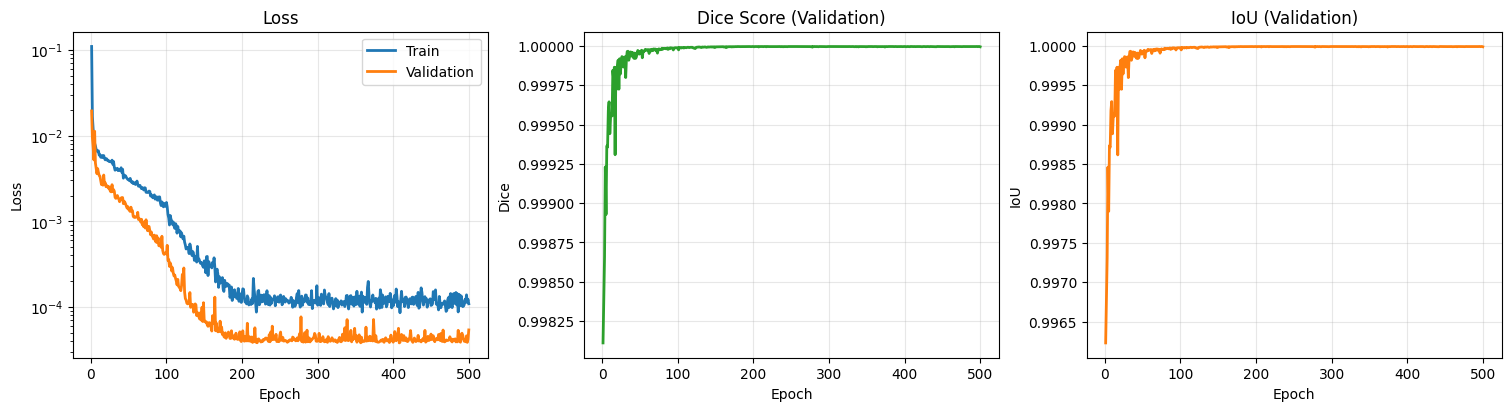

**Using device**: cuda
[Epoch 001/500] train_loss=0.0980 | val_loss=0.0200 | dice=0.9977 | iou=0.9954
[Epoch 002/500] train_loss=0.0200 | val_loss=0.0105 | dice=0.9985 | iou=0.9970
[Epoch 003/500] train_loss=0.0141 | val_loss=0.0078 | dice=0.9988 | iou=0.9975
[Epoch 004/500] train_loss=0.0117 | val_loss=0.0068 | dice=0.9985 | iou=0.9971
[Epoch 005/500] train_loss=0.0092 | val_loss=0.0050 | dice=0.9992 | iou=0.9984
[Epoch 006/500] train_loss=0.0075 | val_loss=0.0042 | dice=0.9993 | iou=0.9986
[Epoch 007/500] train_loss=0.0073 | val_loss=0.0039 | dice=0.9993 | iou=0.9986
[Epoch 008/500] train_loss=0.0064 | val_loss=0.0035 | dice=0.9996 | iou=0.9991
[Epoch 009/500] train_loss=0.0057 | val_loss=0.0032 | dice=0.9996 | iou=0.9992
[Epoch 010/500] train_loss=0.0058 | val_loss=0.0029 | dice=0.9997 | iou=0.9993
[Epoch 011/500] train_loss=0.0057 | val_loss=0.0035 | dice=0.9991 | iou=0.9983
[Epoch 012/500] train_loss=0.0057 | val_loss=0.0037 | dice=0.9990 | iou=0.9980
[Epoch 013/500] train_loss=0.

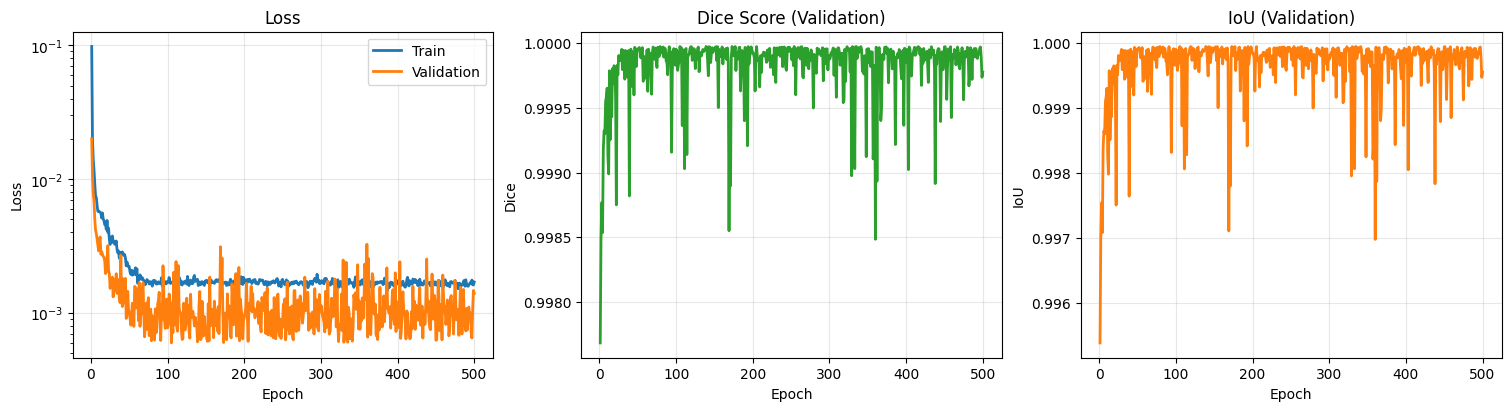

**Using device**: cuda
[Epoch 001/500] train_loss=0.1007 | val_loss=0.0194 | dice=0.9982 | iou=0.9965
[Epoch 002/500] train_loss=0.0165 | val_loss=0.0094 | dice=0.9982 | iou=0.9963
[Epoch 003/500] train_loss=0.0102 | val_loss=0.0058 | dice=0.9991 | iou=0.9982
[Epoch 004/500] train_loss=0.0084 | val_loss=0.0047 | dice=0.9993 | iou=0.9985
[Epoch 005/500] train_loss=0.0068 | val_loss=0.0037 | dice=0.9995 | iou=0.9990
[Epoch 006/500] train_loss=0.0064 | val_loss=0.0036 | dice=0.9994 | iou=0.9988
[Epoch 007/500] train_loss=0.0062 | val_loss=0.0031 | dice=0.9996 | iou=0.9993
[Epoch 008/500] train_loss=0.0055 | val_loss=0.0032 | dice=0.9994 | iou=0.9988
[Epoch 009/500] train_loss=0.0057 | val_loss=0.0035 | dice=0.9993 | iou=0.9986
[Epoch 010/500] train_loss=0.0050 | val_loss=0.0028 | dice=0.9996 | iou=0.9992
[Epoch 011/500] train_loss=0.0054 | val_loss=0.0028 | dice=0.9997 | iou=0.9995
[Epoch 012/500] train_loss=0.0049 | val_loss=0.0026 | dice=0.9997 | iou=0.9995
[Epoch 013/500] train_loss=0.

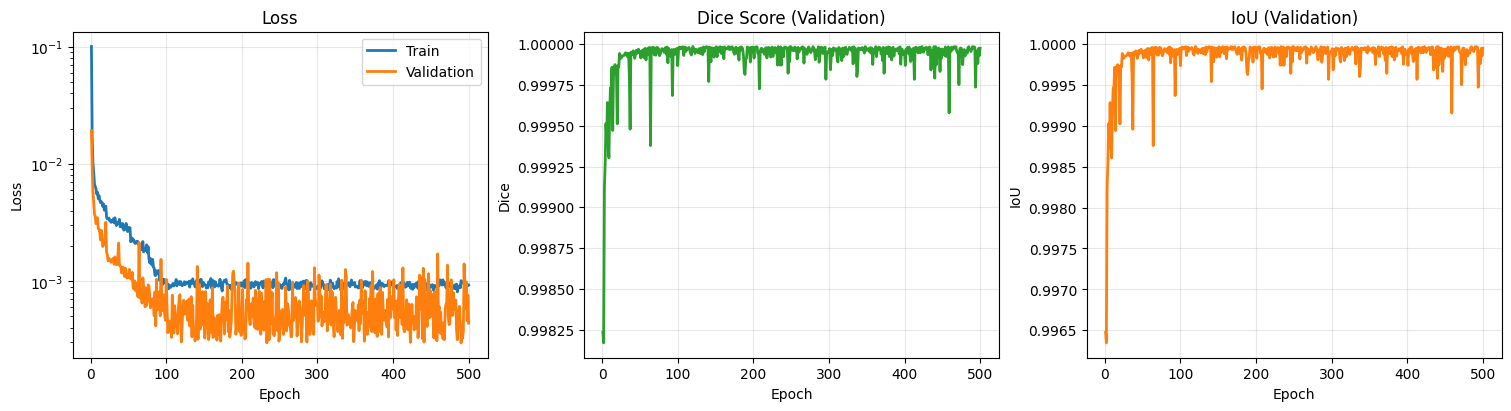

In [10]:
for name in ['Bentheimer', 'Berea', 'Kirby', 'Parker']:
    
    files_lst = load_raw_data(name)

    from scripts.load_data import load_with_keyword_among_list
    filtered = load_with_keyword_among_list(files_lst, 'filtered.raw')
    binary = load_with_keyword_among_list(files_lst, 'binary.raw')

    train_ds, test_ds = make_train_test_paired_datasets(
        filtered.astype(np.float32), binary.astype(np.float32),
        train_slices=700, test_slices=300,
        patch_size=128,
        stride=128,                 # <- control stride here
        sampling="grid",           # "grid" (deterministic) or "random"
        train_max_patches=10000,   # <- control training dataset size here
        test_max_patches=3000,     # keep all test patches (or set a number)
        x_norm="uint8_01",
        channels_first=True,
    )


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print('**Using device**:', device)

    # Example: 2D image-to-image
    # Input channels: 1 (filtered grayscale) or 3 if you stack features
    model = ResUNetPlusPlus2D(in_channels=1, 
                            out_channels=1, 
                            out_activation="none").to(device)

    from networks.train import train_resunetpp_2d, plot_training_history, TrainConfig

    cfg = TrainConfig(
        epochs=500,
        batch_size=16,
        num_workers=0,
        lr=2e-4,
        grad_clip=1.0,
        amp=True,
        save_dir=f"checkpoints_resunetpp_2d_{name}",
    )

    model, best, history = train_resunetpp_2d(model, train_ds, test_ds, cfg)
    plot_training_history(history, name + '__training_history__.png')
    
    with open(f'{name}__training_history__.pkl', 'wb') as f:
        pickle.dump(history, f)
    with open(f'{name}__best__.pkl', 'wb') as f:
        pickle.dump(best, f)
    with open(f'{name}__model__.pkl', 'wb') as f:
        pickle.dump(model, f)


In [ ]:
from scripts.pipeline import Step, run_pipeline
from scripts.denoising import denoise_fourier, denoise_non_local_means, denoise_tv
from scripts.segmentation import segment_otsu, segment_watershed_labels
from scripts.contrast_control import contrast_stretch
from scripts.visualization import plot_pipeline_with_hists

PIPELINE = [
    Step("fourier", denoise_fourier),
    Step("nlm", denoise_non_local_means),
    Step("contrast_stretch", contrast_stretch),
    Step("tv", denoise_tv),
    Step("otsu", segment_otsu),                  # returns mask
    # Step("watershed", segment_watershed_labels), # takes mask -> labels
]

PARAMS = {
    "fourier": dict(kind="lowpass", cutoff_high=0.16, transition=0.04, preserve_dtype=True,
    ),

    "nlm": dict(
        patch_size=7,         # bigger patches are more stable in noisy CT
        patch_distance=9,     # wider search reduces speckle
        h=None,
        fast_mode=True,
        preserve_dtype=True,
    ),

    "contrast_stretch": dict(
        p_low=0.5,
        p_high=99.5,
    ),

    "tv": dict(
        weight=0.2,          # stronger edge-aware smoothing to kill boundary halos
        max_num_iter=250,
        eps=2e-4,
        preserve_dtype=True,
    ),

    "otsu": dict(
        pore_is_dark=True,
        min_size=25,         # aggressively remove tiny false pores
        opening_radius=0,     # stronger cleanup
        closing_radius=0,
    ),

    # "watershed": dict(
    #     mask_is_pore=True,
    #     min_size=0,
    #     opening_radius=0,
    #     closing_radius=0,
    #     peak_footprint_radius=3,  # fewer markers -> less over-segmentation
    #     min_peak_distance=5,      # enforce separation between seeds
    #     compactness=0.0,
    #     connectivity=1,
    # ),
}


In [16]:
%matplotlib qt5

In [19]:
# Select a single 2D slice from the raw 3D CT volume - Assumes raw has shape [Z, H, W]
raw_image = raw[0]
# Run the full digital rock processing pipeline on the slice
result = run_pipeline(raw_image, PIPELINE, PARAMS)
# Visualize the pipeline results:
plot_pipeline_with_hists(raw_image, result, PIPELINE);

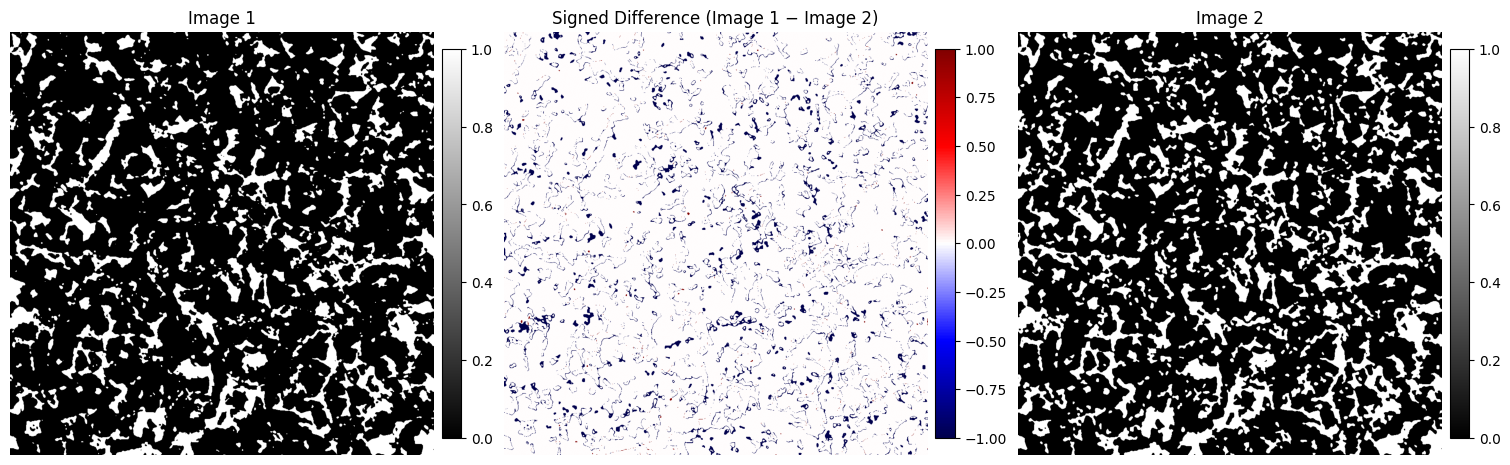

In [279]:
# difference between new and old filtered images:
from scripts.visualization import show_signed_difference_3col
show_signed_difference_3col(
    image_1=1-binary[0],         # <- from the digital rock portal dataset
    image_2=result["images"][-2] # <- from our pipeline
)

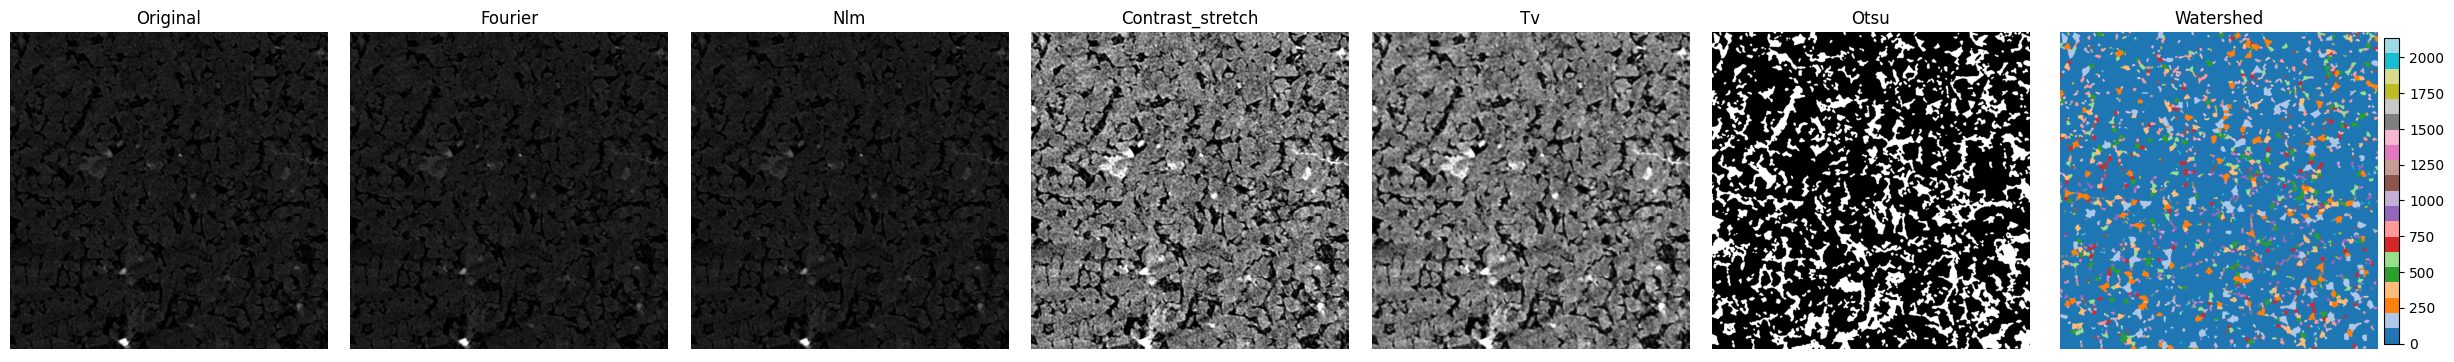

In [ ]:
# (appendix) you can also visualize using another function:
from scripts.visualization import show_pipeline_results
show_pipeline_results(raw_image, result, PIPELINE);

---

(outdated_demo)

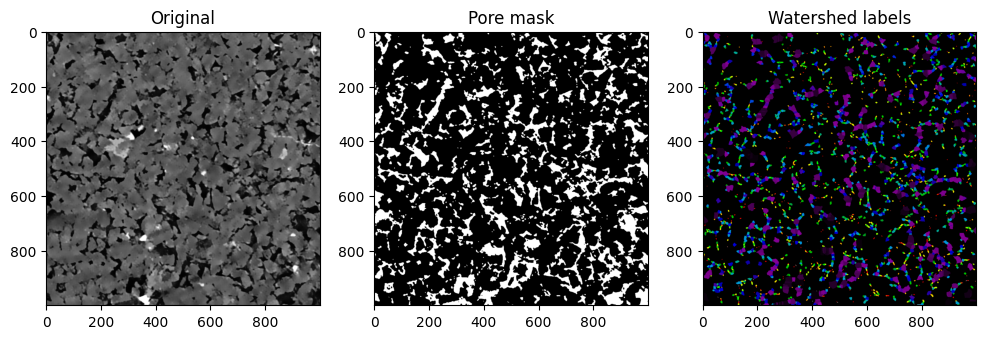

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation, feature
from scipy import ndimage as ndi

# Suppose img is your normalized grayscale image
img = filtered[0,:,:]
# Step 1: threshold (Otsu)
T = filters.threshold_otsu(img)
pore = img < T

# Clean small noise
pore = morphology.remove_small_objects(pore, 5)

# Step 2: distance transform
dist = ndi.distance_transform_edt(pore)

# Step 3: find markers
coords = feature.peak_local_max(dist, footprint=np.ones((3,3)), labels=pore)
markers = np.zeros_like(dist, dtype=int)
for i, (r,c) in enumerate(coords, start=1):
    markers[r,c] = i

# Step 4: watershed
labels = segmentation.watershed(-dist, markers, mask=pore)

# Visualize
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(pore, cmap='gray'); plt.title("Pore mask")
plt.subplot(1,3,3); plt.imshow(labels, cmap='nipy_spectral'); plt.title("Watershed labels")
plt.show()


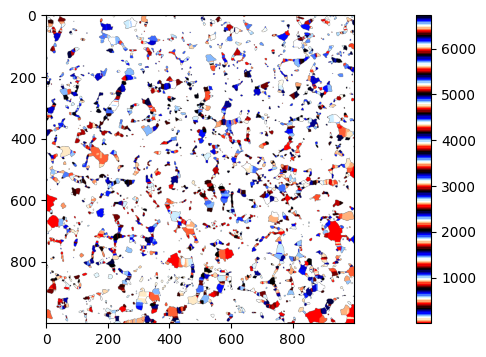

In [83]:
plt.figure(figsize=(16,4))
labels=labels.astype(float)
labels[labels==0] = np.nan  # Hide background for better visualization
plt.imshow(labels, cmap='flag')
plt.colorbar()

In [85]:
labels

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 19., 19., 19.],
       [nan, nan, nan, ..., 19., 19., 19.],
       [nan, nan, nan, ..., 19., 19., 19.]])

(array([562., 488., 388., 525., 399., 409., 389., 332., 318., 286., 197.,
        164., 109.,  86.,  81.,  76.,  63.,  37.,  33.,  26.,  17.,   8.,
          6.,   2.,   2.]),
 array([0.77815125, 0.87069188, 0.96323251, 1.05577314, 1.14831376,
        1.24085439, 1.33339502, 1.42593565, 1.51847628, 1.6110169 ,
        1.70355753, 1.79609816, 1.88863879, 1.98117942, 2.07372005,
        2.16626067, 2.2588013 , 2.35134193, 2.44388256, 2.53642319,
        2.62896382, 2.72150444, 2.81404507, 2.9065857 , 2.99912633,
        3.09166696]),
 <BarContainer object of 25 artists>)

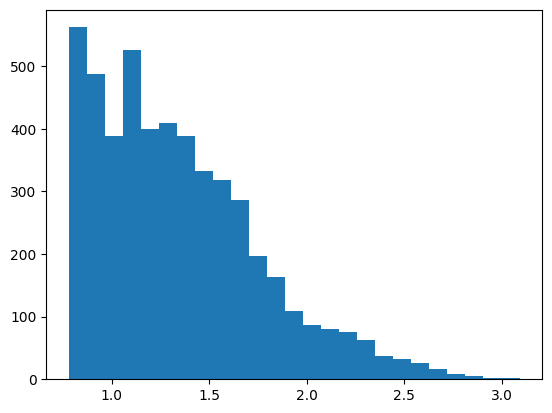

In [98]:
# psd = []
# for i in range(1, labels.max()+1):
#     psd.append(np.sum(labels == i))
psd = np.array(psd)
psd = psd[psd>4]  # Remove zero entries
plt.hist(np.log10(psd), bins=25)

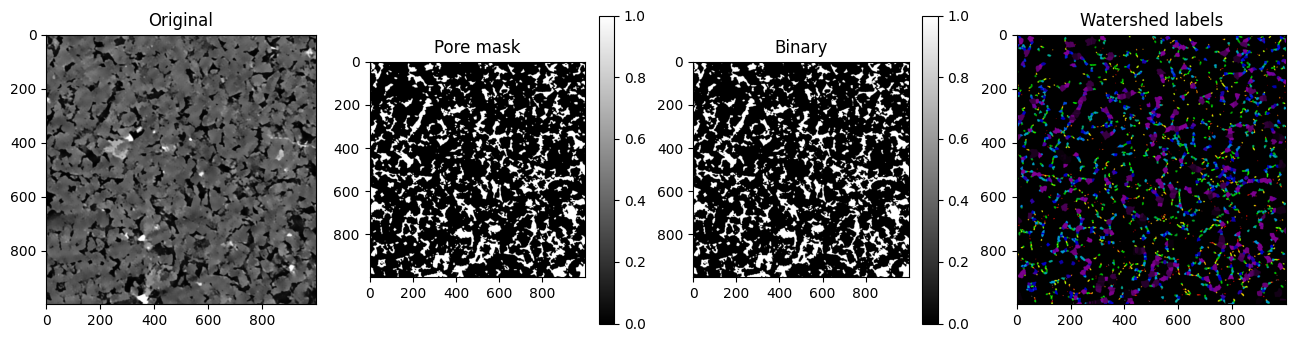

In [68]:
# Visualize
plt.figure(figsize=(16,4))
plt.subplot(1,4,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,4,2); plt.imshow(pore, cmap='gray'); plt.title("Pore mask")
plt.colorbar()
plt.subplot(1,4,3); plt.imshow(1- binary[0,:,:], cmap='gray'); plt.title("Binary")
plt.colorbar()
plt.subplot(1,4,4); plt.imshow(labels, cmap='nipy_spectral'); plt.title("Watershed labels")
plt.show()
